# Panel Data from Finnish Meterological Institute

## 1. Preparation

### 1.1 Libraries

In [1]:
import numpy as np 
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error

# We will use networx objects to store empircial graphs, local datasets and models
import networkx as nx 
from sklearn.neighbors import kneighbors_graph
from numpy import linalg as LA

### 1.2 Helper functions

In [2]:
# The function generates a scatter plot of nodes (=FMI stations) using 
# latitude and longitude as coordinates. 
def plotFMI(G_FMI): 
    num_stations = len(G_FMI.nodes)
    coords = [G_FMI.nodes[i]['coord'] for i in range(num_stations)]
    df_coords = pd.DataFrame(coords,columns=['latitude','longitude'])
    coords = np.hstack((df_coords["latitude"].to_numpy().reshape(-1,1),df_coords["longitude"].to_numpy().reshape(-1,1)))
    # Create a plot.
    fig, ax = plt.subplots()
    # Draw nodes and add labels.
    for node in G_FMI.nodes:
        ax.scatter(coords[node,1], coords[node,0], color='black', s=4, zorder=5)  # zorder ensures nodes are on top of edges
        ax.text(coords[node,1]+0.1, coords[node,0]+0.2, str(node), fontsize=8, ha='center', va='center', color='black', fontweight='bold')
    # Draw edges.
    for edge in G_FMI.edges:
        ax.plot([coords[edge[0],1],coords[edge[1],1]], [coords[edge[0],0],coords[edge[1],0]], linestyle='-', color='gray')

    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    ax.set_title('FMI stations')
    plt.show()
    
    
# The function connects each FMI station with 
# the nearest neighbours. 
def add_edges(graph, numneighbors=4):
    coords = [graph.nodes[i]['coord'] for i in range(num_stations)]
    df_coords = pd.DataFrame(coords,columns=['latitude','longitude'])
    coords = np.hstack((df_coords["latitude"].to_numpy().reshape(-1,1),df_coords["longitude"].to_numpy().reshape(-1,1)))
    A = kneighbors_graph(coords, numneighbors, mode='connectivity', include_self=False)
    nrnodes = len(graph.nodes)
    for iter_i in range(nrnodes): 
        for iter_ii in range(nrnodes): 
            if iter_i != iter_ii : 
                if A[iter_i,iter_ii]> 0 :
                    graph.add_edge(iter_i, iter_ii)
    return graph


# The function computes the average of the local loss 
# incurred by given local odel parameters.
def compute_train_err(graph, localparam):
   
    nrnodes = len(graph.nodes)
    tmp = 0 
    
    for iter_i in range(nrnodes): 
        predictions = np.ones((graph.nodes[iter_i]['samplesize'],1))*localparam[iter_i]
        local_loss = mean_squared_error(graph.nodes[iter_i]['y'], predictions) 
        tmp += local_loss
    
    train_err = tmp / nrnodes
            
    return train_err


# The function computes the total variation 
# of local model parameters.
def compute_totalvariation(graph,localparam):
   
    nrnodes = len(graph.nodes)
    tmp = 0 
    
    total_var = 0
    for u, v in graph.edges():
        total_var += (localparam[u] - localparam[v])**2
       
    return total_var


# The function below extracts a feature and label from each row 
# of dataframe df. Each row is expected to hold a FMI weather 
# measurement with cols "Latitude", "Longitude", "temp", "Timestamp" 
# returns numpy arrays X, y.
def ExtractFeaureMatrixLabvelVector(data):
    nrfeatures = 7 
    nrdatapoints = len(data)
    X = np.zeros((nrdatapoints, nrfeatures))
    y = np.zeros((nrdatapoints, 1))

    # Iterate over all rows in dataframe and create corresponding feature vector and label.
    for ind in range(nrdatapoints):
        # Latitude of FMI station, normalized by 100.
        lat = float(data['Latitude'].iloc[ind])/100
        # Longitude of FMI station, normalized by 100.
        lon = float(data['Longitude'].iloc[ind])/100
        # Temperature value of the data point.
        tmp = data['temp'].iloc[ind]
        # Read the date and time of the temperature measurement. 
        date_object = datetime.strptime(data['Timestamp'].iloc[ind], '%Y-%m-%d %H:%M:%S')
        # Extract year, month, day, hour, and minute. Normalize these values 
        # to ensure that the features are in range [0,1].
        year = float(date_object.year)/2025
        month = float(date_object.month)/13
        day = float(date_object.day)/32
        hour = float(date_object.hour)/25
        minute = float(date_object.minute)/61
        X[ind,:] = [lat, lon, year, month, day, hour, minute]
        y[ind,:] = tmp

    return X, y

## 2 Data

### 2.1 Dataset

In [3]:
# Import the weather measurements.
data = pd.read_csv('FMIData.csv')

# We consider each temperature measurement (=a row in dataframe) as a 
# separate data point.
# Get the numbers of data points and the unique stations.
num_stations = len(data.name.unique())
num_datapoints = len(data)

### 2.2 Panel = Network * Time-Series

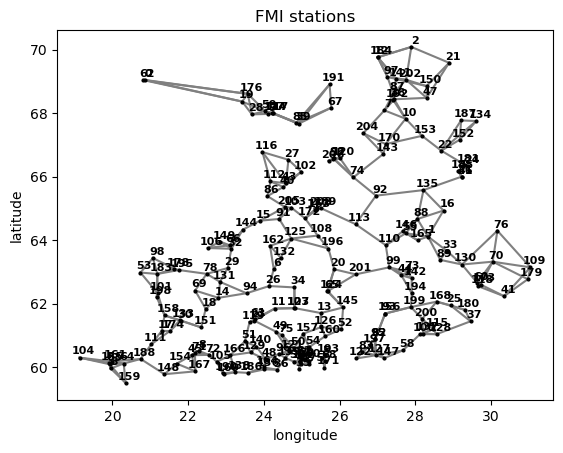

In [5]:
# Create a networkX graph.
G_FMI = nx.Graph()

# Add a one node per station.
G_FMI.add_nodes_from(range(0, num_stations))

# Add node attributes: station name, feature, and label.
yglobal = np.array([])

for i, station in enumerate(data.name.unique()):
    # Extract data of a certain station.
    station_data = data[data.name==station]

    # Assuming the timestamp and temperature are in a single column, we need to split it
# Let's say the original column with combined data is named 'Timestamp'
# We create two new columns by splitting the 'Timestamp' column
#df[['datetime', 'temp']] = df['Timestamp'].str.rsplit(' ', 1, expand=True)
    df = station_data.copy()
# Convert the 'datetime' column to datetime type
    df['datetime'] = pd.to_datetime(df['Timestamp'])

# Convert the 'temp' column to numeric type
    df['temp'] = pd.to_numeric(df['temp'])

# Now you can set the 'datetime' column as the index if you want a time series
    df.set_index('datetime', inplace=True)

# Optionally, sort the DataFrame by datetime to organize it chronologically
    df.sort_index(inplace=True)


    G_FMI.nodes[i]['temp'] = df[['temp']]
    
    # Extract features and labels.
    X, y = ExtractFeaureMatrixLabvelVector(station_data)
    
    localsamplesize = len(y)
    G_FMI.nodes[i]['m'] = localsamplesize # The number of measurements of the i-th weather station
    G_FMI.nodes[i]['X'] = X # The feature matrix for local dataset at node i
    G_FMI.nodes[i]['name'] = station # The name of the i-th weather station
    G_FMI.nodes[i]['coord'] = (station_data.Latitude.unique()[0], station_data.Longitude.unique()[0]) # The coordinates of the i-th weather station 
    G_FMI.nodes[i]['y'] = y  # The label vector for local dataset at node i
    yglobal = np.append(yglobal, y)

# Add edges between each station and its nearest neighbors.
# NOTE: the node degree might be different for different nodes.
numneighbors = 3
G_FMI = add_edges(G_FMI, numneighbors=numneighbors)

# Visualize the empirical graph.
plotFMI(G_FMI)


<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

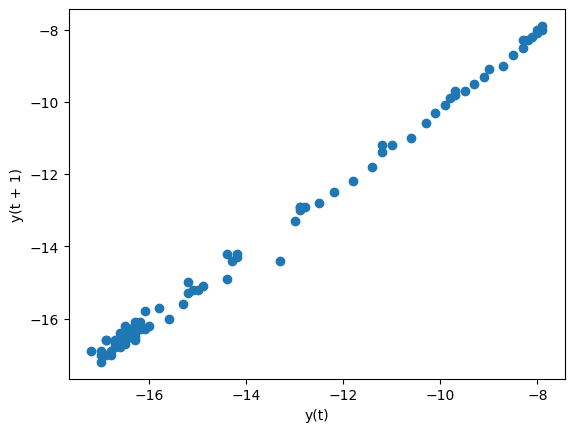

In [6]:
pd.plotting.lag_plot(G_FMI.nodes[0]['temp'], lag=1)

[None]

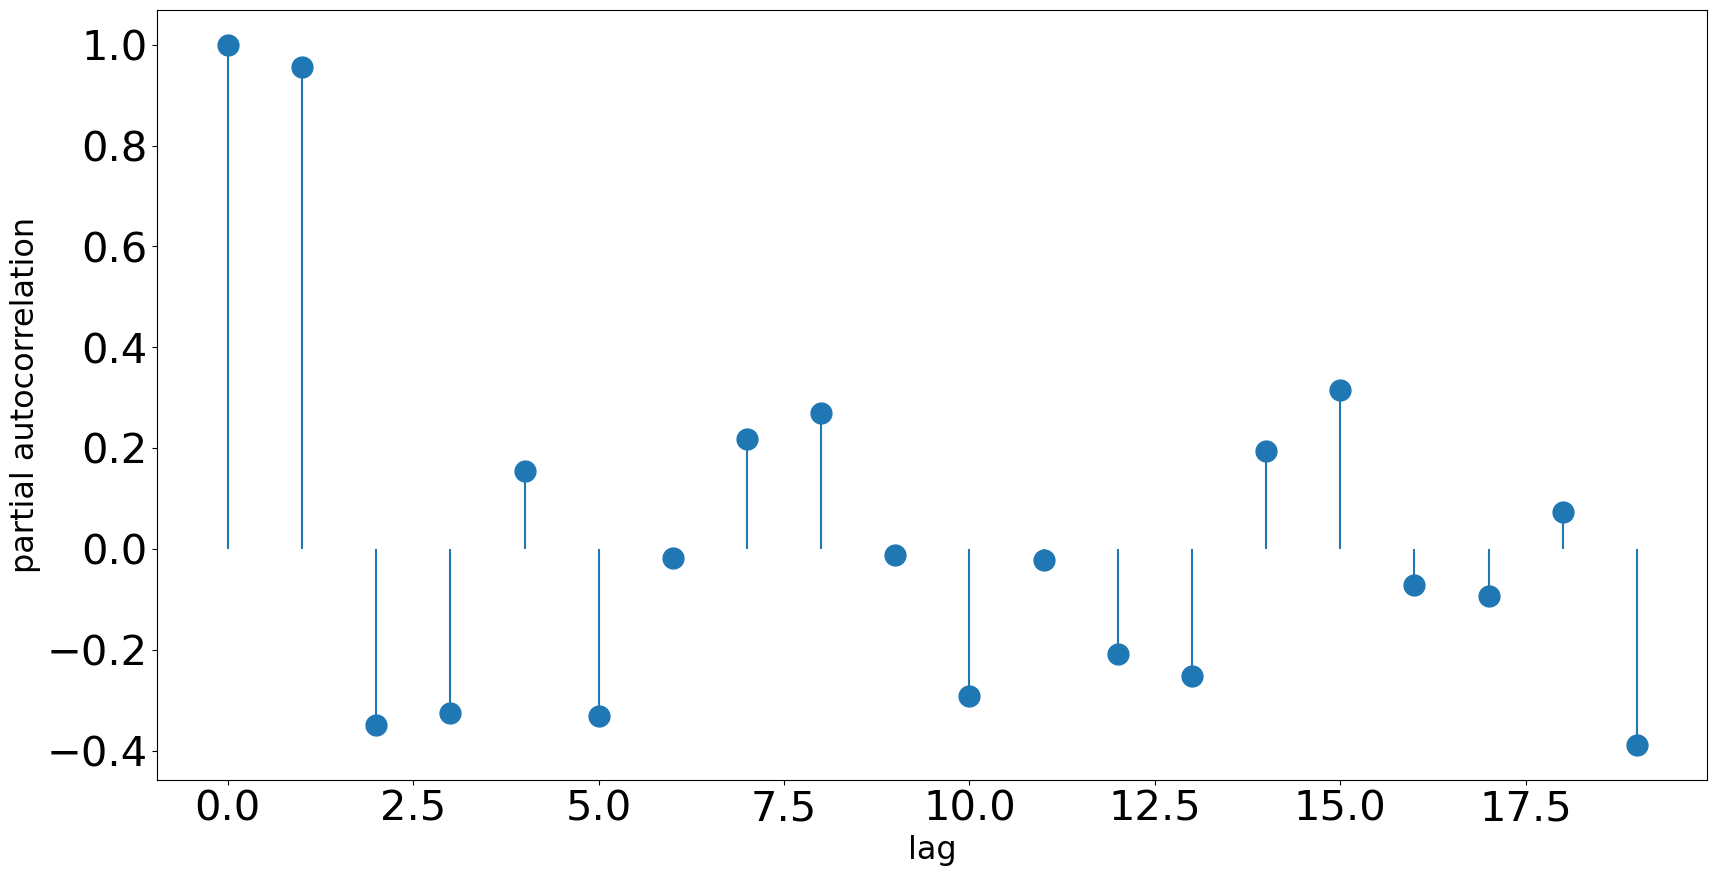

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf, acf

timeseries = G_FMI.nodes[2]['temp'].values

fig, axs = plt.subplots(1,figsize=(20,10))
markerline, stemline, baseline, = axs.stem(pacf(timeseries), basefmt=" ")
axs.tick_params(axis='both', which='major', labelsize=30)
axs.set_ylabel('partial autocorrelation',fontsize=23)
axs.set_xlabel('lag',fontsize=23)
plt.setp(markerline, markersize = 15)
